# Data Analysis on e2e dataset

## Introduction

## Load essential libraries

In [1]:
# import libraries
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

In [3]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy.linalg import norm
from models.w2vec_model import *
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
#from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from pandas.tools.plotting import scatter_matrix

seed = 42

warnings.filterwarnings('ignore')

## Quick look at the data

In [4]:
import pandas as pd
data_train = pd.read_csv("../data/trainset.csv")
fake_train = pd.read_csv('../data/fake_data_train.csv')

In [5]:
#label fake data with 1 and real data with 0 then merge the datasets.
data_train['label'] = '0'
fake_train['label'] = '1'
frames = [data_train, fake_train]
dfs = pd.concat(frames)

In [6]:
#drop Unnamed column
dfs = dfs.drop(dfs.columns[0], axis=1)
#shuffle rows

data = dfs.sample(frac=1).reset_index(drop=True)
data

,label,mr,ref
0,1,"name[Alimentum], food[English], priceRange[mod...","Alimentum Chinese, near the riverside, by Yipp..."
1,1,"name[Giraffe], eatType[coffee shop], priceRang...",Enjoy traditional English food from Giraffe at...
2,0,"name[Giraffe], eatType[pub], food[Fast food], ...",Giraffe is a child-friendly riverside pub serv...
3,0,"name[Strada], eatType[pub], food[Chinese], cus...","Chinese-serving pub, Strada, has a customer ra..."
4,1,"name[Zizzi], eatType[coffee shop], priceRange[...",The pub Zizzi is a family friendly place to ea...
5,0,"name[The Waterman], eatType[pub], food[Fast fo...",The Waterman pub serves delicious fast food an...
6,1,"name[The Mill], eatType[pub], food[Fast food],...",In the area of city centre is a pub called The...
7,0,"name[Fitzbillies], eatType[coffee shop], food[...",The Fitzbillies is a coffee shop that is rated...
8,1,"name[Midsummer House], food[English], priceRan...",Midsummer House is by the Café Rouge. It serve...
9,0,"name[Midsummer House], food[French], customer ...",Midsummer House is a five star restaurant loc...


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85129 entries, 0 to 85128
Data columns (total 3 columns):
label    85129 non-null object
mr       85129 non-null object
ref      85129 non-null object
dtypes: object(3)
memory usage: 1.9+ MB


## Text Analysis

In this section we will perform text analysis on our data. The text analysis will involve :
<ol>
    <li>Removing all non-alphanumeric characters</li>
</ol>

In [8]:
import numpy as np
import keras.backend as K
import string
from nltk.corpus import stopwords
import re
from numpy.linalg import norm
import csv

#stop_words = stopwords.words('english')


def reshape_data(sentence_1_data, sentence_2_data, y_data):
    '''
    Reshapes the input data.
    :param sentence_1_data: sentence 1
    :param sentence_2_data: sentence 2
    :param y_data: output
    :return: a reshaped sentence 1, sentence 2, output
    '''
    # sentence 1
    sentence_1 = np.array(sentence_1_data)
    sentence_1 = sentence_1.reshape(sentence_1.shape +  (1, ))
    
    # sentence 2
    sentence_2 = np.array(sentence_2_data)
    sentence_2 = sentence_2.reshape(sentence_2.shape + (1,))
    
    # y
    y = np.array(y_data)
    y  = y.reshape((y.shape[0], 1))
    
    return sentence_1, sentence_2, y



def clean_str(txt):
    '''
    Cleans a text by removing all non alphanumeric characters.
    :param txt: String, the input sentence.
    :return: A cleaned sentence.
    '''
    txt = str(txt)
    txt = re.sub(r"[^A-Za-z0-9(),!?\'\`&%]", " ", txt)
    txt = re.sub(r"\'s", " \'s", txt)
    txt = re.sub(r"\'ve", " \'ve", txt)
    txt = re.sub(r"\'t", " n\'t", txt)
    txt = re.sub(r"\'re", " \'re", txt)
    txt = re.sub(r"\'d", " \'d", txt)
    txt = re.sub(r"\'ll", " \'ll", txt)
    txt = re.sub(r",", " , ", txt)
    txt = re.sub(r"!", " ! ", txt)
    txt = re.sub(r"\(", " ( ", txt)
    txt = re.sub(r"\)", " ) ", txt)
    txt = re.sub(r"\?", " ? ", txt)
    txt = re.sub(r"\&", " & ", txt)
    txt = re.sub(r"\%", " percent ", txt)
    txt = txt.strip().lower()
    return txt

def remove_punctuation(txt):
    '''
    Removes punctuations in a given sentence.
    :param txt: String, input sentence.
    :return: a list of words from the input sentence without punctuation.
    '''
    return [w for w in txt if w not in string.punctuation]


def remove_stopwords(txt):
    '''
    Removes english stopword in a given sentence.
    :param txt: String, the input sentence.
    :return: A list of words from the input sentence without any stopwords.
    '''
    return [w for w in txt if w not in stop_words]



def fbeta(y_true, y_pred, threshold_shift=0, beta=1):
    '''
    Compute fbeta score.
    :param y_true: y_true
    :param y_pred: predicted value
    :param threshold_shift: threshold
    :param beta: beta value
    :return: fbeta score
    '''
    
    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)
    y_true = K.clip(y_true, 0, 1)
    
    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)
    
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())




def cosine_sim(u, v):
    '''
    Computes the cosine similarity between two vectors u and v.
    :param u: Numpy ndarray, the vector u.
    :param v: Numpy ndarray, the vector v.
    :return: Float between 0 and 1, the cosine similarity score between the vector u and v.
    '''
    return np.dot(u,v) / (norm(u)*norm(v))


def similarity(q1, q2):
    '''
    Computes the similarity score between lists of vectors.
    :param q1: List of the first vector.
    :param q2: List of the second vector.
    :return: A list of similarity score between vectors in q1 and q2.
    '''
    sim = []
    for el1, el2 in zip(q1, q2):
        sim.append(cosine_sim(el1, el2))Saving the results 

    return sim

def save_result(filename, results):
    '''
    Saves a dictionary of data into a file.
    :param filename: String, the filename
    :param results: The dictionary to save into the file
    '''
    keys = results[0].keys()
    with open(filename, 'w') as f:
        dict_writer = csv.DictWriter(f,  keys)
        dict_writer.writeheader()
        dict_writer.writerows(results)

def make_accuracy(threshold_shift):
    '''
    Creates an accuracy function with a given threshold.
    :param threshold_shift: Float, threshold
    :return: An accuracy function
    '''
    def accuracy(y_true, y_pred):
        '''
        Compute accuracy score
        :param y_true: actual output
        :param y_pred: predicted output
        :return: accuracy score
        '''
        y_pred = K.clip(y_pred, 0, 1)
        y_pred = K.round(y_pred + threshold_shift)
        return K.mean(K.equal(y_true, y_pred))
    return accuracy
    

def make_fbeta(threshold_shift):
    '''
    Creates fbeta function with a given threshold.
    :param threshold_shift: Float, threshold shift
    :return: An fbeta function
    '''
    def fbeta(y_true, y_pred, beta=1):
        '''
        Computes the fbeta score.
        :param y_true: y_true
        :param y_pred: predicted value
        :param beta: beta value.
        :return: fbeta score.
        '''
        # just in case of hipster activation at the final layer
        y_pred = K.clip(y_pred, 0, 1)
        y_true = K.clip(y_true, 0, 1)
        
        # shifting the prediction threshold from .5 if needed
        y_pred_bin = K.round(y_pred + threshold_shift)
        
        tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
        fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
        fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        
        beta_squared = beta ** 2
        return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    
    return fbeta

def get_w2v_vector(model, sentence, vector_size):
    '''
    Get the word2vec vector of a given sentence.
    :param model: word2vec model
    :param sentence: sentence
    :param vector_size: vector size
    :return: a word2vec vector of a given sentence
    '''
    sentence_len = len(sentence)
    sentence2vec = np.zeros(shape=(sentence_len, vector_size), dtype='float32')
    for i in range(sentence_len):
        word = sentence[i]
        word_vector = model[word]
        sentence2vec[i] = word_vector
    return sentence2vec


Using TensorFlow backend.


In [9]:

# Remove all non-alphanumeric token in our corpus
data['mr'] = data['mr'].apply(clean_str)
data['ref'] = data['ref'].apply(clean_str)

In [10]:
data.head()

,label,mr,ref
0,1,"name alimentum , food english , pricerange...","alimentum chinese , near the riverside , by ..."
1,1,"name giraffe , eattype coffee shop , price...",enjoy traditional english food from giraffe at...
2,0,"name giraffe , eattype pub , food fast foo...",giraffe is a child friendly riverside pub serv...
3,0,"name strada , eattype pub , food chinese ...","chinese serving pub , strada , has a custome..."
4,1,"name zizzi , eattype coffee shop , pricera...",the pub zizzi is a family friendly place to ea...


In [11]:
elt = data.mr.append(data.ref)

In [12]:

for i in range(5):
    print("Mr: {0}".format(data['mr'][i]))
    print("Ref: {0}".format(data['ref'][i]))
    if data['label'][i] == 0:
        print("is not fake")
    else:
        print("is fake")
        
    print(' ')

Mr: name alimentum  ,  food english  ,  pricerange moderate  ,  customer rating 3 out of 5  ,  area city centre  ,  near yippee noodle bar
Ref: alimentum chinese ,  near the riverside ,  by yippee noodle bar is more than  30 and is also highly rated by customers
is fake
 
Mr: name giraffe  ,  eattype coffee shop  ,  pricerange more than  30  ,  customer rating 5 out of 5  ,  familyfriendly no  ,  near the bakers
Ref: enjoy traditional english food from giraffe at riverside
is fake
 
Mr: name giraffe  ,  eattype pub  ,  food fast food  ,  area riverside  ,  familyfriendly yes
Ref: giraffe is a child friendly riverside pub serving fast food
is fake
 
Mr: name strada  ,  eattype pub  ,  food chinese  ,  customer rating average  ,  near yippee noodle bar
Ref: chinese serving pub ,  strada ,  has a customer rating of average and is located near yo yippee noodle bar
is fake
 
Mr: name zizzi  ,  eattype coffee shop  ,  pricerange high  ,  customer rating 1 out of 5  ,  area riverside  ,  fami

## Visualization

In this section, we will perform some visualizations

In [13]:
d = data.groupby(['label'])[['mr']].count()

In [14]:
d

,mr
label,
0,42061
1,43068


In [15]:
d['mr']/data.shape[0] * 100

label
0    49.408545
1    50.591455
Name: mr, dtype: float64

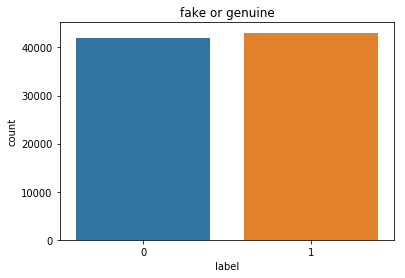

In [16]:
sns.countplot(x='label', data=data)
plt.title('fake or genuine')
plt.show()

Our dataset has roughly 63% of nonduplicate entries and 37% of duplicate entries. Next, let's look at the questions length distribution.

In [17]:
data['mr'] = data['mr'].apply(lambda x: x.split())
data['ref'] = data['ref'].apply(lambda x: x.split())

In [18]:
data['mr_len'] = data['mr'].apply(len)
data['ref_len'] = data['ref'].apply(len)

In [19]:
data.head()

,label,mr,ref,mr_len,ref_len
0,1,"[name, alimentum, ,, food, english, ,, pricera...","[alimentum, chinese, ,, near, the, riverside, ...",24,22
1,1,"[name, giraffe, ,, eattype, coffee, shop, ,, p...","[enjoy, traditional, english, food, from, gira...",25,8
2,0,"[name, giraffe, ,, eattype, pub, ,, food, fast...","[giraffe, is, a, child, friendly, riverside, p...",15,10
3,0,"[name, strada, ,, eattype, pub, ,, food, chine...","[chinese, serving, pub, ,, strada, ,, has, a, ...",17,20
4,1,"[name, zizzi, ,, eattype, coffee, shop, ,, pri...","[the, pub, zizzi, is, a, family, friendly, pla...",22,15


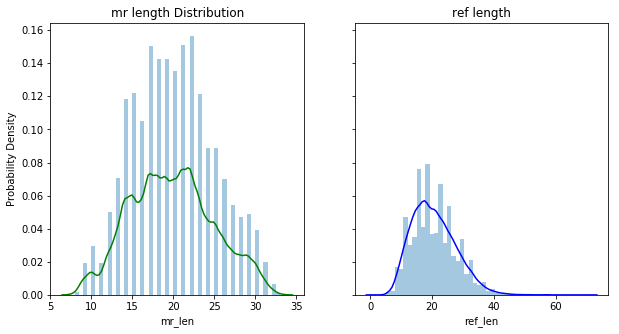

In [20]:
# what is the age distribution?
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))
sns.distplot(data['mr_len'],kde_kws={'color': 'green'}, ax=axs[0], label='mr');
axs[0].set(title='mr length Distribution')
axs[0].set(ylabel='Probability Density')
sns.distplot(data['ref_len'], kde_kws={'color': 'blue'}, ax=axs[1], label='ref' );
axs[1].set(title='ref length')
plt.show()

Both sentences are right skewed.

In [21]:

data.drop(['mr_len', 'ref_len'], axis=1, inplace=True)

In [22]:

data.shape

(85129, 3)

## Prepare our data for a convolutional neural network model

In this section, we will make our data suitable for a convolutional neural network archittecture. We will perform the following steps:
<ol>
    <li>Pad our sentences with empty string to make them have the same length. </li>
    <li>Build our word representations model and replace all question text with their corresponding vector space representations.</li>
    <li>Split our data into training data and test data.</li>
</ol>

### 1. Pad sentences

In other for our sentences to all have the same length, we have padded with empty string all sentences that have a number of tokens less than 40, and we have taken only the first 40 tokens for sentences that have more than 40 tokens.

In [23]:
data_cnn = data.copy()

In [24]:
data_cnn.head()

,label,mr,ref
0,1,"[name, alimentum, ,, food, english, ,, pricera...","[alimentum, chinese, ,, near, the, riverside, ..."
1,1,"[name, giraffe, ,, eattype, coffee, shop, ,, p...","[enjoy, traditional, english, food, from, gira..."
2,0,"[name, giraffe, ,, eattype, pub, ,, food, fast...","[giraffe, is, a, child, friendly, riverside, p..."
3,0,"[name, strada, ,, eattype, pub, ,, food, chine...","[chinese, serving, pub, ,, strada, ,, has, a, ..."
4,1,"[name, zizzi, ,, eattype, coffee, shop, ,, pri...","[the, pub, zizzi, is, a, family, friendly, pla..."


In [25]:
# take only the first words 
data_cnn['mr'] = data_cnn['mr'].apply(lambda x: x + ['']*(40 - len(x)) if len(x) < 40 else x[:40])
data_cnn['ref'] = data_cnn['ref'].apply(lambda x: x + ['']*(40 - len(x)) if len(x) < 40 else x[:40])

In [26]:
data_cnn.head()

,label,mr,ref
0,1,"[name, alimentum, ,, food, english, ,, pricera...","[alimentum, chinese, ,, near, the, riverside, ..."
1,1,"[name, giraffe, ,, eattype, coffee, shop, ,, p...","[enjoy, traditional, english, food, from, gira..."
2,0,"[name, giraffe, ,, eattype, pub, ,, food, fast...","[giraffe, is, a, child, friendly, riverside, p..."
3,0,"[name, strada, ,, eattype, pub, ,, food, chine...","[chinese, serving, pub, ,, strada, ,, has, a, ..."
4,1,"[name, zizzi, ,, eattype, coffee, shop, ,, pri...","[the, pub, zizzi, is, a, family, friendly, pla..."


### 2. Word representations

In [27]:

# get all the questions
questions = data_cnn['mr'].append(data_cnn['ref'], ignore_index=True).tolist()

In [28]:
import multiprocessing
# build word2vec model using only 100 features
num_features = 100
min_word_count = 1
num_workers = multiprocessing.cpu_count()
context_size = 5
downsampling = 1e-3
seed = 42
sg=1

In [29]:
import gensim.models.word2vec as w2v
import multiprocessing
import numpy as np

FILENAME = '../models/model.w2v'
class Word2VecModel(object):
    '''In domain word embeddings model using word2vec algorithm'''
    def __init__(self):
        self._model = None
        self.filename = FILENAME
        
    @classmethod
    def from_file(cls, filename):
        self = cls()
        self._model = w2v.Word2Vec.load(filename)
        self.filename = filename
        return self
        
    def create_w2v_model(self, sentences, num_features, min_word, context,
                         sg, downsampling, seed):
        '''
        Builds the word2vec model from a corpus of text.
        :param sentences: List of list of string, the corpus.
        :param num_features: Integer, embedding length.
        :param min_word: Integer, the algorithm will ignore all word with frequency lower than min_word.
        :param context: Integer, window size, the maximum distance between the current and predicted word within the sentence.
        :param sg: Integer - 0 or 1 -, which indicates whether to use the skip-gram archittecture (1), or the continuous bag of words archittecture (0).
        :param downsampling: Threshold for configuring which higher-frequency words are randomly downsampled;
        :param seed: Integer, a random seed.
        :return: the word2vec model
        '''
    
        # define parameters
        num_features = num_features
        min_word_count = min_word
        num_workers = multiprocessing.cpu_count()
        context = context
        downsampling = downsampling
    
        # create model
        model = w2v.Word2Vec(sg=sg, seed=seed,  workers=num_workers, \
                             size=num_features, min_count=min_word_count, \
                             window=context, sample=downsampling )
    
        model.build_vocab(sentences)
        model.train(sentences, total_examples=model.corpus_count, epochs=model.iter )
        self._model = model
        model.save(self.filename)

    def get_w2v_vector(self, sentence, vector_size):
        '''
        Gets the word representations of a given sentence.
        :param sentence: List of string, the input sentence.
        :param vector_size: Integer, embedding size.
        :return: A list of word representations.
        '''
    
        sentence_len = len(sentence)
        sentence2vec = np.zeros(shape=(sentence_len, vector_size), dtype='float32')
        for i in range(sentence_len):
            word = sentence[i]
            word_vector = self._model[word]
            sentence2vec[i] = word_vector
    
        return sentence2vec

In [30]:
model = Word2VecModel()
model.create_w2v_model(questions, num_features, min_word_count, context_size,
                         sg, downsampling, seed)

In [31]:

data_cnn['mr'] = data_cnn['mr'].apply(lambda x: get_w2v_vector(model._model, x, vector_size=100))
data_cnn['ref'] = data_cnn['ref'].apply(lambda x: get_w2v_vector(model._model, x, vector_size=100))

### 3. Split data

In this section, we will split the data into training and test sets. We won't use all the data, we will take all the records with 'is_duplicate' value of 1 and randomly select records with 'is_duplicate' value of 0. The final dataset will have the same proportion of duplicate and non-duplicate data.

In [32]:
# get the shape
data_cnn.shape

(85129, 3)

In [33]:

# get the shape
data_cnn.shape
data_cnn

,label,mr,ref
0,1,"[[-0.37908638, 0.1638139, 0.20259914, -0.09383...","[[-0.1818145, 0.25963646, -0.2614064, -0.44578..."
1,1,"[[-0.37908638, 0.1638139, 0.20259914, -0.09383...","[[-0.1690446, 0.9572438, -0.47049683, 0.367934..."
2,0,"[[-0.37908638, 0.1638139, 0.20259914, -0.09383...","[[-0.35820436, -0.23095846, 0.34594697, -0.147..."
3,0,"[[-0.37908638, 0.1638139, 0.20259914, -0.09383...","[[-0.058310073, -0.16320723, 0.08698093, 0.139..."
4,1,"[[-0.37908638, 0.1638139, 0.20259914, -0.09383...","[[0.10664042, -0.10619072, -0.34475988, 0.0431..."
5,0,"[[-0.37908638, 0.1638139, 0.20259914, -0.09383...","[[0.10664042, -0.10619072, -0.34475988, 0.0431..."
6,1,"[[-0.37908638, 0.1638139, 0.20259914, -0.09383...","[[-0.14107366, 0.0032092547, -0.4267622, -0.07..."
7,0,"[[-0.37908638, 0.1638139, 0.20259914, -0.09383...","[[0.10664042, -0.10619072, -0.34475988, 0.0431..."
8,1,"[[-0.37908638, 0.1638139, 0.20259914, -0.09383...","[[0.31176493, -0.592992, -0.5378497, -1.011767..."
9,0,"[[-0.37908638, 0.1638139, 0.20259914, -0.09383...","[[0.31176493, -0.592992, -0.5378497, -1.011767..."


In [34]:
# split a data into fake and not fake
data_fake = data_cnn[data_cnn['label'] == '1']
data_nonfake = data_cnn[data_cnn['label'] == '0']
data_fake

,label,mr,ref
0,1,"[[-0.37908638, 0.1638139, 0.20259914, -0.09383...","[[-0.1818145, 0.25963646, -0.2614064, -0.44578..."
1,1,"[[-0.37908638, 0.1638139, 0.20259914, -0.09383...","[[-0.1690446, 0.9572438, -0.47049683, 0.367934..."
4,1,"[[-0.37908638, 0.1638139, 0.20259914, -0.09383...","[[0.10664042, -0.10619072, -0.34475988, 0.0431..."
6,1,"[[-0.37908638, 0.1638139, 0.20259914, -0.09383...","[[-0.14107366, 0.0032092547, -0.4267622, -0.07..."
8,1,"[[-0.37908638, 0.1638139, 0.20259914, -0.09383...","[[0.31176493, -0.592992, -0.5378497, -1.011767..."
10,1,"[[-0.37908638, 0.1638139, 0.20259914, -0.09383...","[[-0.18332575, 0.10209053, 0.035914343, -0.054..."
11,1,"[[-0.37908638, 0.1638139, 0.20259914, -0.09383...","[[0.10664042, -0.10619072, -0.34475988, 0.0431..."
12,1,"[[-0.37908638, 0.1638139, 0.20259914, -0.09383...","[[-0.10867459, -0.2720276, -0.10706063, -0.592..."
13,1,"[[-0.37908638, 0.1638139, 0.20259914, -0.09383...","[[0.10664042, -0.10619072, -0.34475988, 0.0431..."
14,1,"[[-0.37908638, 0.1638139, 0.20259914, -0.09383...","[[-0.084962554, 0.09476538, 0.022652943, 0.060..."


In [35]:

# get the number of fake 
number_elt = data_fake.shape[0]

In [36]:

# sample non duplicate data so that fake and non fake have the same size
non_fake = data_nonfake.sample(n=number_elt, random_state=seed, replace=True)

In [37]:
data_cnn_final = pd.concat([non_fake, data_fake])


In [38]:
# split the data into training and test dataset 
train, test = train_test_split(data_cnn_final, test_size=0.1, random_state=seed)

In [39]:
print(train.shape)
print(test.shape)

(77522, 3)
(8614, 3)


Our data is ready to be used in a convolutional neural network archittecture.

## Prepare data for xgboost model

In this section, we will prepare our data to be suitable for XGBoost model.
We will perform the following step:
<ol>
    <li>Prepare our text data by removing punctuation and stopwords.</li>
    <li>Perform additional features engineering.</li>
    <li>Split the data into train, test</li>
</ol>


### 1. Remove punctuations and stopwords

### 2. Features engineering

We will perform the following features engineering on our data:
<ol>
<li>Similarity score between the two questions of each record.</li>
<li>Number of words in question 1.</li>
<li>Number of words in question 2.</li>
<li>Number of unique token in question 1.</li>
<li>Number of unique token in question 2.</li>
<li>Number of unique shared token between question 1 and question 2.</li>
</ol>

#### 2.1 Similarity score

In [40]:
### save data for xgboost learning
train.to_pickle('../data/train.pickle')
test.to_pickle('../data/test.pickle')

In this section, we have prepared our dataset for the xgboost learning model. 

In [41]:
# get a copy 
data_xgb = data.copy()

In [42]:

import string
def remove_punctuation(txt):
    '''
    Removes punctuations in a given sentence.
    :param txt: String, input sentence.
    :return: a list of words from the input sentence without punctuation.
    '''
    return [w for w in txt if w not in string.punctuation]

In [43]:
# remove punctuation in our corpus
data_xgb['mr'] = data_xgb['mr'].apply(lambda x: remove_punctuation(x))
data_xgb['ref'] = data_xgb['ref'].apply(lambda x: remove_punctuation(x))


In [44]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def remove_stopwords(txt):
    '''
    Removes english stopword in a given sentence.
    :param txt: String, the input sentence.
    :return: A list of words from the input sentence without any stopwords.
    '''
    return [w for w in txt if w not in stop_words]

In [45]:
# remove stopwords in our corpus
data_xgb['mr'] = data_xgb['mr'].apply(remove_stopwords)
data_xgb['ref'] = data_xgb['ref'].apply(remove_stopwords)

In [46]:
data_xgb.head()

,label,mr,ref
0,1,"[name, alimentum, food, english, pricerange, m...","[alimentum, chinese, near, riverside, yippee, ..."
1,1,"[name, giraffe, eattype, coffee, shop, pricera...","[enjoy, traditional, english, food, giraffe, r..."
2,0,"[name, giraffe, eattype, pub, food, fast, food...","[giraffe, child, friendly, riverside, pub, ser..."
3,0,"[name, strada, eattype, pub, food, chinese, cu...","[chinese, serving, pub, strada, customer, rati..."
4,1,"[name, zizzi, eattype, coffee, shop, pricerang...","[pub, zizzi, family, friendly, place, eat, 3, ..."


In [47]:
##prepare the data to build the LSA model
data1 = data_xgb.mr
data2 = data_xgb.ref
data_q1 = []
data_q2 = []
q1_q2 = []
for d in data1:
    d1 = ' '.join(d)
    data_q1.append(d1)
    
for d in data2:
    d2 = ' '.join(d)
    data_q2.append(d2)
# our document set consist of all the questions: questions1 and questions2    
q1_q2 = data_q1 + data_q2

In [48]:
svd_clf = make_pipeline(TfidfVectorizer(min_df=1),
                               TruncatedSVD(algorithm='arpack', n_components=100, random_state=seed))
svd_clf

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...vd', TruncatedSVD(algorithm='arpack', n_components=100, n_iter=5, random_state=42,
       tol=0.0))])

In [49]:
# fit the model
svd_clf.fit(q1_q2)

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...vd', TruncatedSVD(algorithm='arpack', n_components=100, n_iter=5, random_state=42,
       tol=0.0))])

In [50]:
# apply trainsform to mr and ref  to get SVD vectors
mr_transform = svd_clf.transform(data_q1)
ref_transform = svd_clf.transform(data_q2)

In [51]:
def similarity(q1, q2):
    '''
    Computes the similarity score between lists of vectors.
    :param q1: List of the first vector.
    :param q2: List of the second vector.
    :return: A list of similarity score between vectors in q1 and q2.
    '''
    sim = []
    for el1, el2 in zip(q1, q2):
        sim.append(cosine_sim(el1, el2))

    return sim

In [52]:

def cosine_sim(u, v):
    '''
    Computes the cosine similarity between two vectors u and v.
    :param u: Numpy ndarray, the vector u.
    :param v: Numpy ndarray, the vector v.
    :return: Float between 0 and 1, the cosine similarity score between the vector u and v.
    '''
    return np.dot(u,v) / (norm(u)*norm(v))

In [53]:

# similarity score
sim = similarity(mr_transform, ref_transform)

In [54]:
data_xgb['similarity'] = sim

In [55]:
data_xgb.head()

,label,mr,ref,similarity
0,1,"[name, alimentum, food, english, pricerange, m...","[alimentum, chinese, near, riverside, yippee, ...",0.507777
1,1,"[name, giraffe, eattype, coffee, shop, pricera...","[enjoy, traditional, english, food, giraffe, r...",0.422604
2,0,"[name, giraffe, eattype, pub, food, fast, food...","[giraffe, child, friendly, riverside, pub, ser...",0.592895
3,0,"[name, strada, eattype, pub, food, chinese, cu...","[chinese, serving, pub, strada, customer, rati...",0.851517
4,1,"[name, zizzi, eattype, coffee, shop, pricerang...","[pub, zizzi, family, friendly, place, eat, 3, ...",0.290657


In [56]:
# other feature engineering
### number of word in question 1
data_xgb['q1_len'] = data_xgb['mr'].apply(len)
### number of word in question 2
data_xgb['q2_len'] = data_xgb['ref'].apply(len)
### number of unique word in question 1
data_xgb['q1_voc_len'] = data_xgb['mr'].apply(lambda x: len(list(set(x))))
### number of unique word in question 2
data_xgb['q2_voc_len'] = data_xgb['ref'].apply(lambda x: len(list(set(x))))
### number of unique word in both question 1 and question 2
data_xgb['shared_token_len'] = data_xgb.apply(lambda row: len(list(set(row['mr']) & set(row['ref']))), axis=1 )

In [57]:
data_xgb.head()

,label,mr,ref,similarity,q1_len,q2_len,q1_voc_len,q2_voc_len,shared_token_len
0,1,"[name, alimentum, food, english, pricerange, m...","[alimentum, chinese, near, riverside, yippee, ...",0.507777,17,12,17,12,5
1,1,"[name, giraffe, eattype, coffee, shop, pricera...","[enjoy, traditional, english, food, giraffe, r...",0.422604,14,6,13,6,1
2,0,"[name, giraffe, eattype, pub, food, fast, food...","[giraffe, child, friendly, riverside, pub, ser...",0.592895,11,8,10,8,5
3,0,"[name, strada, eattype, pub, food, chinese, cu...","[chinese, serving, pub, strada, customer, rati...",0.851517,13,13,13,13,10
4,1,"[name, zizzi, eattype, coffee, shop, pricerang...","[pub, zizzi, family, friendly, place, eat, 3, ...",0.290657,15,9,15,9,2


In [58]:
# remove nan
# remove NAN iN similarity
ind_sim = data_xgb[data_xgb.similarity.isnull()].index

In [59]:
len(ind_sim)

0

In [60]:
data_xgb.drop(ind_sim, inplace=True)

In [61]:
data_xgb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85129 entries, 0 to 85128
Data columns (total 9 columns):
label               85129 non-null object
mr                  85129 non-null object
ref                 85129 non-null object
similarity          85129 non-null float64
q1_len              85129 non-null int64
q2_len              85129 non-null int64
q1_voc_len          85129 non-null int64
q2_voc_len          85129 non-null int64
shared_token_len    85129 non-null int64
dtypes: float64(1), int64(5), object(3)
memory usage: 6.5+ MB


In [62]:

# drop the column we won't need
data_xgb.drop(['mr', 'ref'], axis=1, inplace=True)

In [63]:
data_xgb.head()

,label,similarity,q1_len,q2_len,q1_voc_len,q2_voc_len,shared_token_len
0,1,0.507777,17,12,17,12,5
1,1,0.422604,14,6,13,6,1
2,0,0.592895,11,8,10,8,5
3,0,0.851517,13,13,13,13,10
4,1,0.290657,15,9,15,9,2


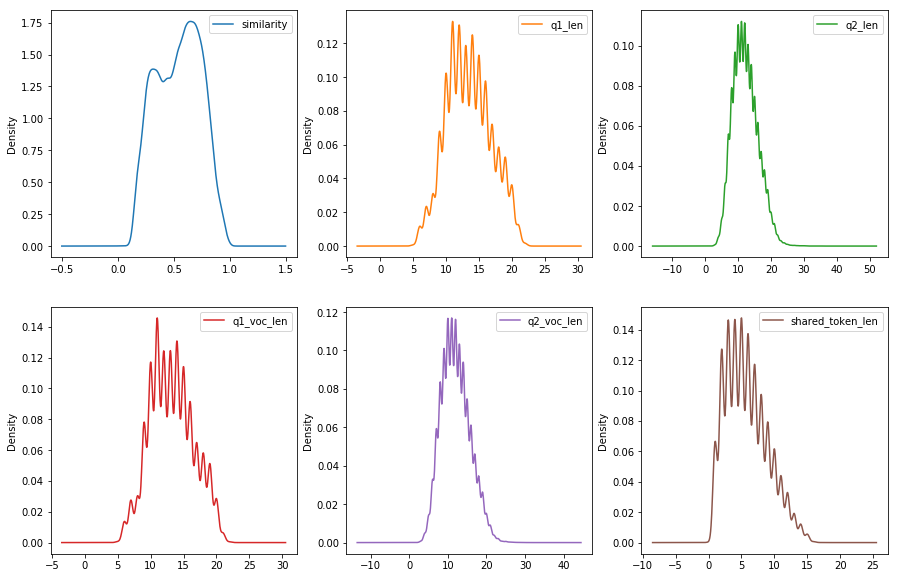

In [64]:

data_xgb[['similarity', 'q1_len', 'q2_len', 'q1_voc_len', 'q2_voc_len', 'shared_token_len']].plot(kind= 'density',
                                                                                                    figsize=(15, 10),
                                                                                                    subplots=True, layout=(2,3),
                                                                                                    sharex=False, sharey=False)
plt.show()

In [65]:

data_xgb_features = data_xgb[['similarity', 'q1_len', 'q2_len', 'q1_voc_len', 'q2_voc_len', 'shared_token_len']]

In [66]:
names = list(data_xgb_features.columns.values)

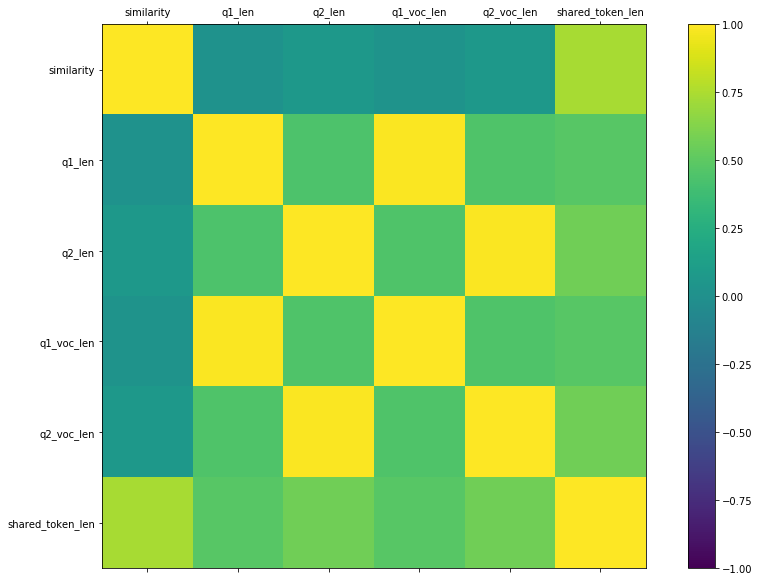

In [67]:
#correlation matrix
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(data_xgb_features.corr(),vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,6,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

In [68]:
# xgboost tree
xgb_model = XGBClassifier()
xgb_model.fit(data_xgb.drop('label',1), data_xgb.label)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

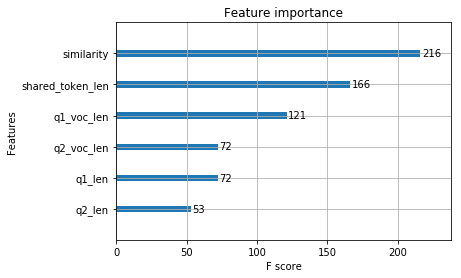

In [69]:
# todo importance figure
plot_importance(xgb_model)
plt.show()

In [70]:
# split the data into training and test dataset 
train_xgb, test_xgb = train_test_split(data_xgb, test_size=0.1, random_state=seed)

In [71]:

### save data for xgboost learning
train_xgb.to_pickle('../data/xgb_train.pickle')
test_xgb.to_pickle('../data/xgb_test.pickle')

In [72]:
import pandas as pd
def make_fbeta(threshold_shift):
    def fbeta(y_true, y_pred, beta=1):
        '''
        Compute fbeta score.
        :param y_true: y_true
        :param y_pred: predicted value
        :param threshold_shift: threshold
        :param beta: beta value
        :return: fbeta score
    
    '''
    # just in case of hipster activation at the final layer
        y_pred = K.clip(y_pred, 0, 1)
        y_true = K.clip(y_true, 0, 1)
    
    # shifting the prediction threshold from .5 if needed
        y_pred_bin = K.round(y_pred + threshold_shift)
    
        tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
        fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
        fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
    
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
    
        beta_squared = beta ** 2
        return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return fbeta

In [73]:
fbeta01 = make_fbeta(0.1)
fbeta02 = make_fbeta(0.2)
fbeta03 = make_fbeta(0.3)
fbeta04 = make_fbeta(0.4)
fbeta00 = make_fbeta(0.0)
fbeta_minus01 = make_fbeta(-0.1)
fbeta_minus02 = make_fbeta(-0.2)
fbeta_minus03 = make_fbeta(-0.3)
fbeta_minus04 = make_fbeta(-0.4)

In [ ]:
import pandas as pd

from models.cnn_model import *
from utils.utils import *
from sklearn.model_selection import train_test_split

# define parameters
filter_size = 32
strides = (1, 1)
padding = 'VALID'
embedding_len = 100
activation = 'relu'
filters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
bias = True
sentence_len = 40
k_initialization = 'glorot_uniform'
b_initialization = 'zeros'
input_shape = (sentence_len, embedding_len, 1)
batch_size = 32
epochs = 100
seed = 10

# define metrics
acc = make_accuracy(0)
fbeta = make_fbeta(0)

FILE_PATH = '../data/train.pickle'
def main():
    # Prepare data
    data_cnn = pd.read_pickle(FILE_PATH)
    train, validation = train_test_split(data_cnn, test_size=0.1, random_state=seed)
    
    ## Traning data
    sentence_1_train = train.mr.tolist()
    sentence_2_train = train.ref.tolist()
    y_train = train.label.tolist()
    question_1_train, question_2_train, y_train = reshape_data(sentence_1_train, sentence_2_train, y_train)
    
    ## Validation data
    sentence_1_validation = validation.mr.tolist()
    sentence_2_validation = validation.ref.tolist()
    y_validation = validation.label.tolist()
    question_1_validation, question_2_validation, y_validation = reshape_data(sentence_1_validation,
                                                                              sentence_2_validation, y_validation)

    # Define the model
    cnn_model = CnnModel(filter_size, strides, padding, embedding_len, activation, filters, k_initialization,
                         b_initialization, input_shape, bias)
    cnn_model.summary()
    cnn_model.compile(loss='mean_squared_error', optimizer='adam', metrics=[acc, fbeta])
    
    # Train the model
    cnn_model.train([question_1_train, question_2_train], y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=([question_1_validation, question_2_validation], y_validation),
                    verbose=2, shuffle=True)
    
if __name__ == '__main__':
    main()

Instructions for updating:
dim is deprecated, use axis instead
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 40, 100, 1)    0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 40, 100, 1)    0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 39, 1, 32)     6432                                         
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 38, 1, 32)     9632                                         
____________________________